In [1]:
import os
import glob
import pickle
import pandas as pd
import numpy as np

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns

In [2]:
DATA_FOLDER="/tmp/"
SCHEDULER="XX.XX.XXX:XXXX"
DATABASES_GLOB = "/tmp/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather"
MOTIF_ANNOTATIONS_FNAME = "/tmp/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"
HS_TFS_FNAME = "/tmp/hs_hgnc_tfs.txt"
SC_EXP_FNAME = "/tmp/ETV6_2020_expression_matrix.txt"

#output files
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs.csv")
ADJAC_FNAME = os.path.join(DATA_FOLDER, "expr_mat.adjacencies.csv")
R_REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons.tsv")
AUCMTX_FNAME = os.path.join(DATA_FOLDER, "auc_mtx.csv")

#Download list of curated human transcription factors from: Lambert SA et al. The Human Transcription Factors. Cell 2018 https://dx.doi.org/10.1016/j.cell.2018.01.029
#https://github.com/aertslab/pySCENIC/blob/master/notebooks/pySCENIC%20-%20List%20of%20Transcription%20Factors.ipynb
#All files are available here : https://github.com/aertslab/pySCENIC/tree/master/resources

In [3]:
ex_matrix = pd.read_csv(SC_EXP_FNAME, sep='\t', header=0, index_col=0).T
ex_matrix.shape

(10312, 21442)

In [4]:
ex_matrix.head()

,MIR1302-2HG,AL627309.1,AL627309.5,AP006222.2,LINC01409,FAM87B,LINC01128,LINC00115,FAM41C,AL645608.6,...,CT45A10,GABRE,MAGEA10,AC116666.1,PNCK,SLC6A8,TKTL1,AC245140.1,AC244090.3,AC233755.1
D6_AAACCTGCATACGCCG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D6_AAACCTGTCAACGGGA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D6_AAAGATGAGTAGGCCA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D6_AAAGCAACAGACGTAG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D6_AAATGCCCATGGGACA,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
tf_names = load_tf_names(HS_TFS_FNAME)

In [6]:
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38__refseq-r80__10kb_up_and_down_tss.mc9nr")]

In [7]:
#Phase I: Inference of co-expression modules

In [8]:
adjacencies = grnboost2(ex_matrix, tf_names=tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished


In [9]:
adjacencies.head()

,TF,target,importance
747,RPL6,RPL26,341.905275
747,RPL6,RPL13,340.711201
747,RPL6,RPS28,318.345218
747,RPL6,RPL17,315.845892
747,RPL6,RPL34,295.173874


In [10]:
adjacencies.to_csv(ADJAC_FNAME)

In [11]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix, keep_only_activating=True, rho_mask_dropouts=True))


2022-06-20 14:01:46,751 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-06-20 14:01:49,155 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2022-06-20 14:03:28,755 - pyscenic.utils - INFO - Creating modules.


In [12]:
# Calculate a list of enriched motifs and the corresponding target genes for all modules.
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

# Create regulons from this table of enriched motifs.
regulons = df2regulons(df)

# Save the enriched motifs and the discovered regulons to disk.
df.to_csv(MOTIFS_FNAME)
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons, f)

[########################################] | 100% Completed | 11min 27.0s
Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [13]:
  f = open(R_REGULONS_FNAME,"w+")
  f.write('\t'.join(["name","gene2weight","TF","context","score\n"]))
  for line in regulons:
    f.write('\t'.join([line.name,str(line.gene2weight),line.transcription_factor,str(line.context),str(line.score)]))
    f.write("\n")
  f.close()

In [14]:
#to check df
#print(df[:10])

#To reload!!!!
#df = load_motifs(MOTIFS_FNAME)
#with open(REGULONS_FNAME, "rb") as f:
#    regulons = pickle.load(f)
print("Number of regulons :")
len(regulons)

Number of regulons :


312

In [15]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=6)

In [16]:
auc_mtx.to_csv(AUCMTX_FNAME)

/opt/conda/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


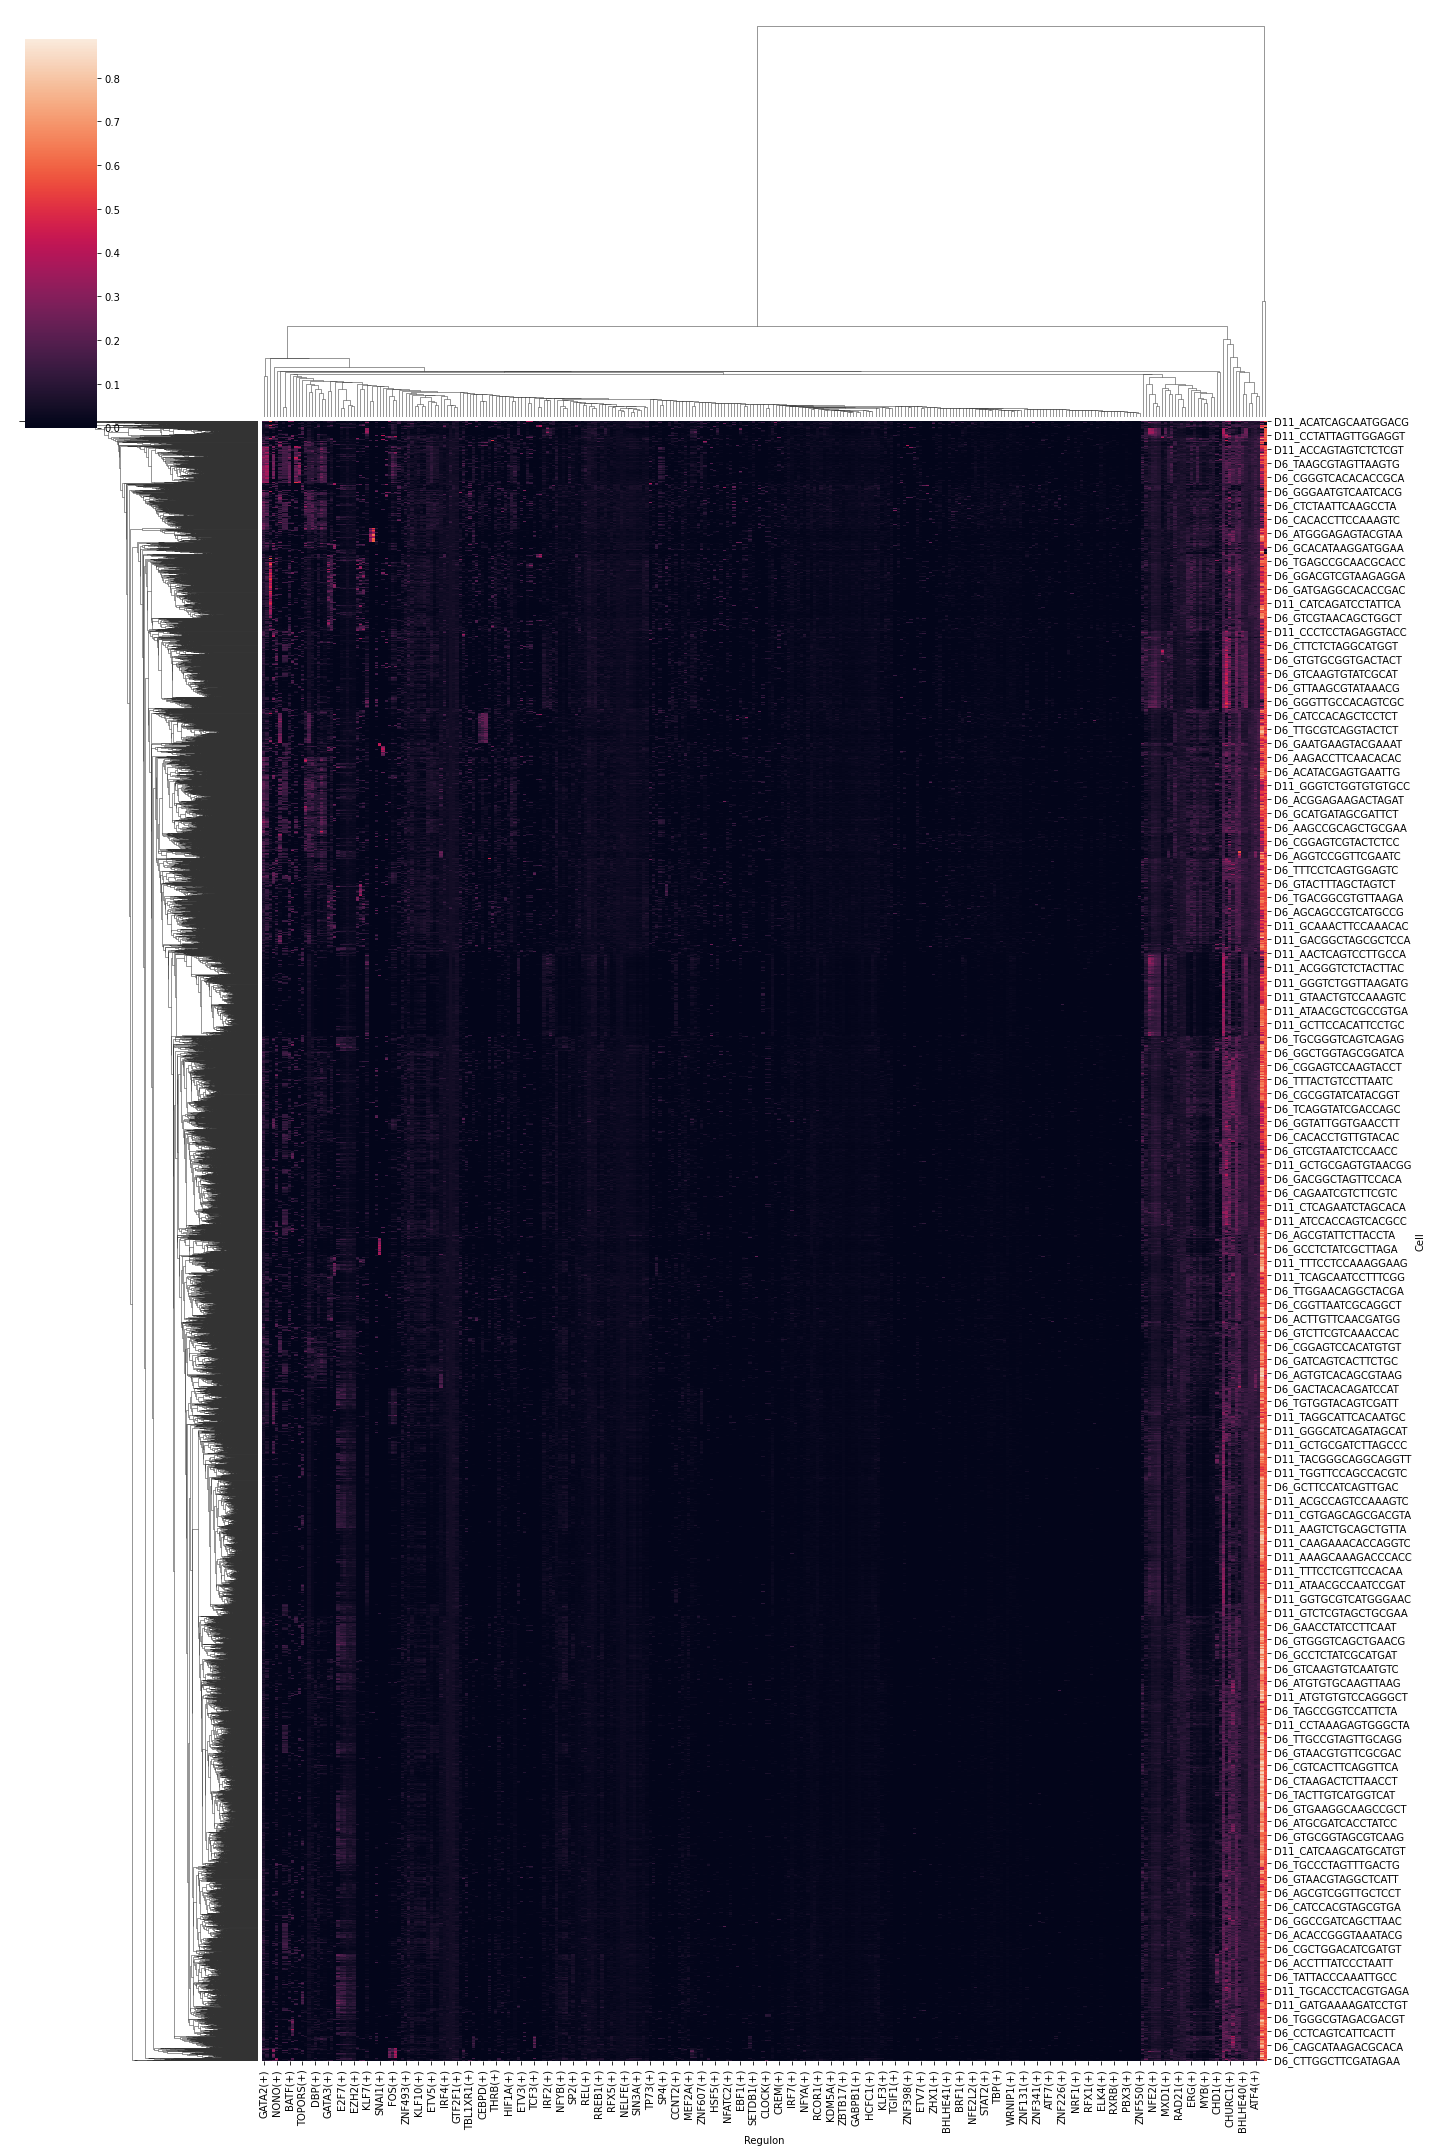

In [17]:
sns.clustermap(auc_mtx, figsize=(20,30))

In [18]:
import sys
sys.version

'3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) \n[GCC 9.3.0]'

In [19]:
type(regulons[74])

pyscenic.genesig.Regulon

In [20]:
regulons[74]

Regulon(name='ETV4(+)', gene2weight=frozendict.frozendict({'ARHGEF7': 4.217920065470964, 'USPL1': 2.642303751640175, 'TAF1A-AS1': 2.881878488480525, 'STK11IP': 4.043104603141187, 'LINC00892': 3.0611462980476998, 'ZKSCAN4': 1.506147895491348, 'FOXJ2': 1.142812157632074, 'CDC42EP4': 0.8288335132882416, 'ATP2A3': 0.3862255390896844, 'NR1H3': 0.6647666045000808, 'SLC7A1': 0.4653833575115233, 'AGTRAP': 0.4516636168828001, 'SMCO4': 2.3487819372235186, 'ARHGEF19': 0.6688840730701691, 'ZNF316': 2.487957520175532, 'ETV4': 1.0, 'OARD1': 0.49958159242238803, 'HYPK': 1.1886579087015299, 'LIPT1': 0.5387669291708146, 'SATB1': 0.6465714624005817, 'GAD1': 4.36371859760403, 'MAP4': 0.6749158075830116, 'AGO3': 0.4656477459443089, 'COX10': 0.8638132988730032}), gene2occurrence=frozendict.frozendict({}), transcription_factor='ETV4', context=frozenset({'activating', 'swissregulon__hs__ELF1_2_4.p2.png'}), score=1.525025254899566, nes=0.0, orthologous_identity=0.0, similarity_qvalue=0.0, annotation='')

In [21]:
modules[394]

Regulon(name='Regulon for MAX', gene2weight=frozendict.frozendict({'HLA-A': 97.81414114453386, 'TYROBP': 85.61578307539122, 'ANGPT1': 84.56856086872044, 'HLA-E': 78.593395724164, 'AL157895.1': 78.06526383950737, 'FNTB': 77.13506805853231, 'AIF1': 74.80516266719445, 'CNST': 71.53742118376644, 'VSIR': 70.67188532521212, 'NCF4': 67.52273138108517, 'HLA-B': 67.08928519604015, 'HLA-C': 65.39264447131984, 'MYCT1': 62.445092705746156, 'SLC40A1': 62.39180097247721, 'TPST2': 62.05209142891797, 'RIN3': 61.150192334003094, 'TFPI': 59.09409250346954, 'HGD': 58.44363753435587, 'RASGRP3': 58.03300570855308, 'SMYD3': 54.17243556302049, 'ITM2B': 53.35022762631474, 'TRBV6-5': 51.94032495848908, 'RGS18': 51.73628929343218, 'RAMP1': 51.371496111015176, 'SERPING1': 51.36316752962958, 'HCK': 50.55792267632488, 'TUBB1': 50.54496892478755, 'RTN4': 50.088670230165526, 'CITED2': 49.70148532782487, 'SERPINB1': 49.47873269388439, 'HCST': 49.294134622542465, 'DNAJB6': 48.88286445625905, 'GPSM3': 48.52744565276295